In [1]:
# HOME
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()

# get the code
import sys
sys.path.append('../scripts')
from codeCNV.plot import plot_snp, plot_2d, plot_3d
from codeCNV.rollingCNV import apply_rolling_SNP, interpolate, one_col_rolling, llh, get_blocks

home = '/Users/mahtin'
# home = '/Users/martinscience'
# standard paths
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
static_path = os.path.join(home, "Dropbox/Icke/Work/static")
cluster_path = os.path.join(home, "mount")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")

# load the config
# edit config directly in yaml file
import yaml
config_file = '../config/config_devel.yaml'
def get_config(config_file, param):
        with open(config_file) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
            config = yaml.load(file, Loader=yaml.FullLoader)['CNV'][param]
        return config
config = get_config(config_file, 'combine')

# 
cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")
cnvPON_path = cnv_path = os.path.join(cnvdata, "chromCov")
cnv_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/cnv")
cnvPON_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/chromCov")

## get the SNP data with FullExonPos

In [2]:
sample = "02_B"
snp_df = pd.read_csv(os.path.join(output_path, f'tmp/{sample}.snpcov.gz'), sep='\t', compression='gzip')
snp_df

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,covCNV,covCNVcore,covCenter,covCentercore,Depth,EBscore,VAF
0,chr1,14930,836,836,1.428618,NaN,NaN,0.0,0.0,0.0,0.0,38.0,0.799,0.105263
1,chr1,14933,839,839,1.438335,NaN,NaN,0.0,0.0,0.0,0.0,39.0,1.239,0.076923
2,chr1,15759,930,930,0.792439,NaN,NaN,0.0,0.0,0.0,0.0,16.0,0.545,0.062500
3,chr1,16949,1410,1410,1.395638,0.289597,0.0,0.0,0.0,0.0,0.0,258.0,0.685,0.286822
4,chr1,17384,1708,1708,0.719626,0.289597,0.0,0.0,0.0,0.0,0.0,292.0,0.402,0.003425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736744,chrX,156025116,49470062,1835599,-0.947821,-0.172361,0.0,0.0,0.0,5028.0,1.0,134.0,1.106,0.522388
736745,chrX,156025122,49470068,1835605,-0.947682,-0.172587,0.0,0.0,0.0,5028.0,1.0,138.0,0.384,0.007246
736746,chrX,156025182,49470128,1835665,-0.893346,-0.174846,0.0,0.0,0.0,5028.0,1.0,143.0,0.508,0.006993
736747,chrX,156025194,49470140,1835677,-0.873213,-0.175298,0.0,0.0,0.0,5028.0,1.0,140.0,0.641,0.007143


### run the code

In [ ]:
snp2_df = apply_rolling_SNP(snp_df, config)
snp2_df.to_csv(os.path.join(output_path, f'CNV/{sample}.roll.snp'), sep='\t', index=False)

### visualize the data

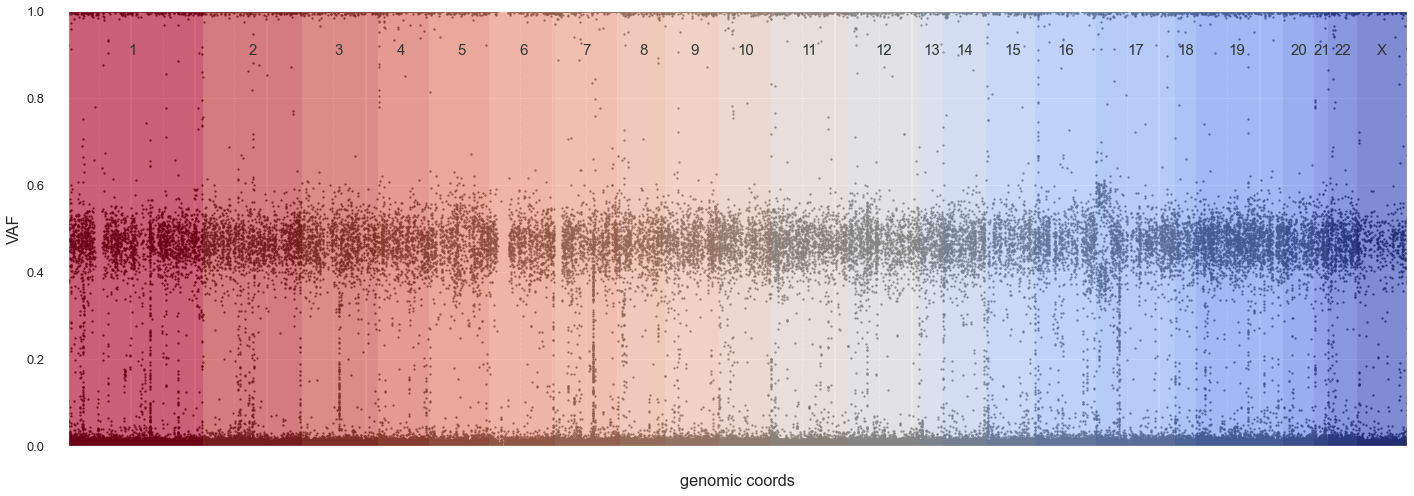

In [4]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vaf = dict(
        title='VAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            s=2,
            color='black',
            alpha=.7
        )
    )

fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)
chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

_ = plot_snp(snp_df, snp_plots=[vaf], chroms='all', region='', **fig_params)
#fig, ax, df, chrom_df

## heteroSNP rolling window
+ #### first, remove the zero SNPs to reduce data
+ #### next, fallSNP have to be remo
+ #### next, important local features have to be extracted:
    * offVAF: distance measure from the meanVAF
    * SNPdensity: measure of genomic spread of SNPs in order to find falling SNPs
    * absVAF: absolute dist measure from meanVAF
    * snpLLH: log-likelihood to belong the center gaussian
    * hsnpLLH: log-likelihood to belong to VAF==1 (to identify high purity clones)

+ #### next, these local features have to be computed with a rolling window to convert local to regional data

In [17]:
def make_get_density(window_size=20):
    '''
    helper for returning a density computer for given window_size
    '''
    
    def SNPdensity(data):
        return (data.max() - data.min()) / window_size
    return SNPdensity

def remove_fallSNP(snp_df, mean=0.5, std=0.2, params={}):
    '''
    removes the falling SNP probably caused by mismapping
    '''
    
    window = params['offVAFwindow']
    cutoff = params['maxFallSNP']
    
    # get the density computer for rolling
    get_SNPdensity = make_get_density(window)
    # cycle through chroms
    chrom_dfs = []
    for chrom in snp_df['Chr'].unique():
        df = snp_df.query('Chr == @chrom')
  
        # get the snp
        df = one_col_rolling(df, df.query('VAF < 0.95'), 'ExonPos', get_SNPdensity, window_size=window, diff_exp=4)
        df.loc[:, 'SNPdensity'] = df['SNPdensity'] / df['SNPdensity'].mean()
    
        # get the offVAFsum
        df = one_col_rolling(df, df.query('VAF < 0.95'), 'offVAF', 'sum', window_size=window, normalize=True, diff_exp=4)
    
        # combine both metrices
        df.loc[:, 'fallSNP'] = df['SNPdensity'] * df['offVAFsum']
        # now remove the ones below average VAFstd
        df = df.query('VAF > @mean - @std / 2 or fallSNP > @cutoff')
        chrom_dfs.append(df)
        
    return pd.concat(chrom_dfs).sort_values('FullExonPos').reset_index(drop=True)


def compute_snp_llh(df, mean=0.5, sigma=0.2):
    '''
    computes the local log-likelihood of belonging to the center gaussian
    '''
        
    print(f"Computing log-likelihood of VAF belonging to center gaussian [mean:{round(mean, 3)}, sigma:{round(sigma,3)}]")
    df.loc[:, 'snpLLH'] = llh(df['VAF'], mean, sigma)
    
    # for homoSNPs reduce the VAFs to the ones above mean
    upper_vafs = df.query('@mean < VAF')['VAF']
    # then compute the hsnpLLH

    print(f"Computing log-likelihood of VAF belonging to purity100  [mean:1, sigma:{round(sigma,3)}]")
    # these are called hsnp
    # upper_vafs only contains half the snps, the remaining have to be interpolated
    df.loc[:, 'hsnpLLH'] = llh(upper_vafs, 1, sigma)
    df = interpolate(df, 'hsnpLLH', expand_limit=50)
    return df
    

def expand_SNPdata(snp_df, config):
    '''
    retrieve a few data columns locally to use rolling windows on
    this needs to be done chromosome-wise in order to avoid gap effects
    VAF limits are also applied here
    '''
        
    # split the params dict for easier access
    params = config['snp']
    filter_params = params['filter']
    # data_params = params['data']
    
    # reduce the snp_df using lower config limit
    # upper limit has to be set later as we still need the homoSNP llh
    VAFmin, VAFmax = filter_params['VAF']
    snp_df = snp_df.query('@VAFmin < VAF')
    
    
    # get std and mean of VAF
    minVAF, maxVAF = params['LLH']['center_range']
    # get the sigma and mean of the center band VAF (extracted as pd.Series center_vafs)
    center_vafs = snp_df.query('@minVAF < VAF < @maxVAF')['VAF']
    # get width of gaussian from std * sigma_factor
    VAFstd = center_vafs.std()
    VAFmean = center_vafs.mean()
    
    
    # get additional features from VAFs
    snp_df.loc[:, 'offVAF'] = (snp_df['VAF'] - VAFmean) * 2
    # absolute values for cluster 
    snp_df.loc[:,'absVAF'] = np.abs(snp_df['offVAF'])    
    
    ########## remove fallSNP ########
    fs_params = params['fallSNP']
    if fs_params['run']:
        print('Removing falling SNPs')
        snp_df = remove_fallSNP(snp_df, mean=VAFmean, std=VAFstd, params=fs_params)
     
    ######## LLH  #####################
    # get the snpLLH and hsnpLLH
    # get config params
    sigma = VAFstd * params['LLH']['sigma_factor']
    # hsnpLLH is computed in order to rescue high absVAF that would have been filtered out
    # lower VAF is already removed because density of VAF ~0 is highly irregular and would confound 
    snp_df = compute_snp_llh(snp_df, mean=VAFmean, sigma=sigma)

    return snp_df.reset_index(drop=True)

In [ ]:
config = get_config(config_file, 'combine')
snp2_df = expand_SNPdata(snp_df, config)

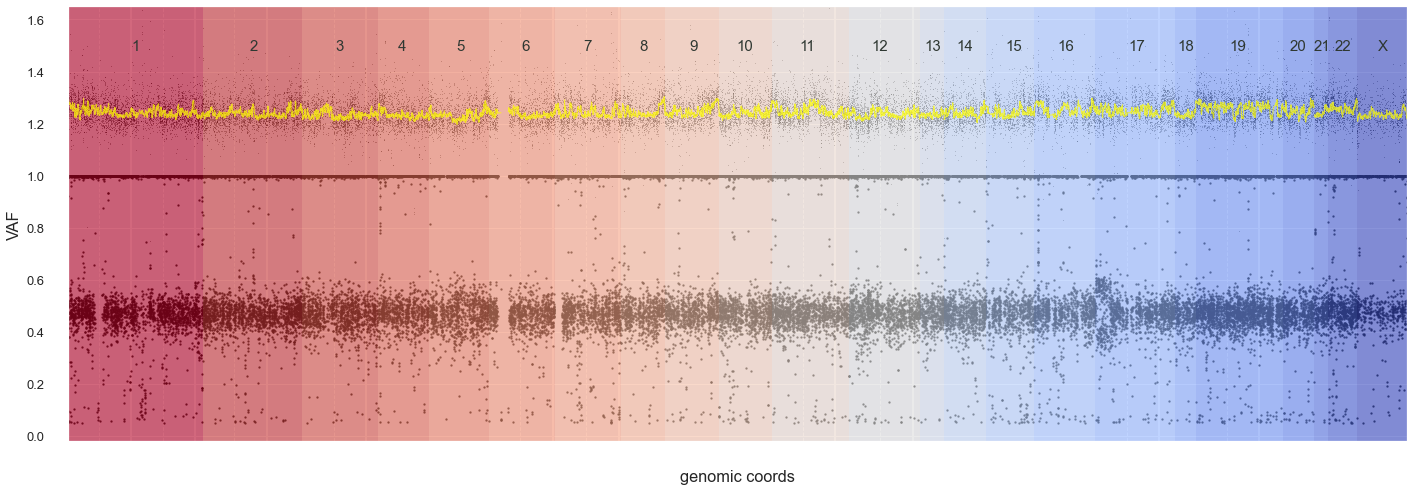

In [28]:
fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-0.02,1.05),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)


absvaf = dict(
        title='absVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=2,
            alpha=1
        ))
deltavaf = dict(
        title='deltaVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='deltaVAF',
        plot_args=dict(
            linewidth=0.5,
            color='green',
            s=5,
            alpha=1
        ))

offvaf = dict(
        title='offVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='offVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))


chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

_ = plot_snp(snp2_df, snp_plots=[vaf], cov_plots=[log2, log2mean], chroms='all', region='', **fig_params)
# fig, ax, df, chrom_df

### remove the fallSNP
+ filter hSNPs against maxVAF
+ compute genomic snp-density (stretch / window)
+ combine with rolling offVAFsum
+ remove the negative offVAF in that range

In [ ]:
config = get_config(config_file, 'combine')
params = config['snp']['fallSNP']
snp_df3 = remove_fallSNP(snp2_df, params=params)

In [ ]:
    _ = plot_snp(snp_df3, snp_plots=[vaf], chroms='all', region='', **fig_params)

In [ ]:
df = snp2_df.copy().query('VAF < 0.95')





ws = 10
gr = make_get_range(window_size=ws)



In [ ]:
density = dict(
        title='density',
        plot_type='line',   # ['line', 'scatter']
        data='range',
        plot_args=dict(
            linewidth=.5,
            color='yellow',
            alpha=.7
        )
    )

fallSNP = dict(
        title='fallSNP',
        plot_type='line',   # ['line', 'scatter']
        data='fallSNP',
        plot_args=dict(
            linewidth=.5,
            color='blue',
            alpha=.7
        )
    )

_ = plot_snp(df, snp_plots=[vaf, fallSNP], chroms='all', region='chr17', **fig_params)

## Rolling SNPdata

In [ ]:
def rolling_SNP(snp_df, config):
    '''
    cycle through the chroms and perform rolling window computations of snp data set in config
    '''

    # split the params dict for easier access
    params = config['snp']
    filter_params = params['filter']
    data_params = params['rolling_data']
    rolling_filter_params = params['rolling_filter']
    debug = config['debug']
    
    
    # reduce the snp_df using config limits
    VAFmin, VAFmax = filter_params['VAF']
    df = snp_df.query('@VAFmin < VAF < @VAFmax').reset_index(drop=True)
    
    minDepth = filter_params['minDepth']
    

    # cycle through chroms for
    chrom_dfs = []
    for chrom in snp_df['Chr'].unique():
        # restrict to chrom
        chrom_df = snp_df.query('Chr == @chrom').sort_values('FullExonPos')
        # filter df
        # 
        filter_df = chrom_df.query(
            'Depth >= @minDepth')
        for data_col in data_params.keys():
            for agg in data_params[data_col].keys():
                window_size = data_params[data_col][agg]
                expand_limit = int(params['expand'] * window_size)
                # show_output(f"Computing rolling window for {agg} of {data_col} with window size {window_size} on {chrom}")
                chrom_df = one_col_rolling(chrom_df, filter_df, data_col, agg, window_size=window_size,
                                           expand_limit=expand_limit, normalize=params['normalize'], debug=config['debug'], ddof=config['ddof'])
        chrom_dfs.append(chrom_df)
    df = pd.concat(chrom_dfs).sort_values('FullExonPos')

    # now do global normalization for sum aggregations:
    # cycle through rolling_data
    for data_col in data_params.keys():
        for agg in data_params[data_col].keys():
            # only do normalization for sum aggregations
            if not agg == "sum":
                continue
            print(f"Normalizing {data_col} {agg}")
            # get the columns for normalization
            col_name = data_col + agg
            cols = [col_name]
            if debug:
                cols += [f'{col_name}L', f'{col_name}R']

            for c in cols:

                _min = df[c].min()
                _max = df[c].max()
                df.loc[:, c] = (df[c] - _min) / (_max - _min)
    return df

### test rolling windows

In [ ]:
config = get_config(config_file, 'combine')
snp3_df = rolling_SNP(snp2_df, config)
snp3_df

## optimizing rolling windows

### VAF
+ std  (20)
+ var

In [ ]:
vaf = dict(
        title='VAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))

vafstd = dict(
        title='VAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='VAFstd',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vafstddiff = dict(
        title='VAFstdDiff',
        plot_type='line',   # ['line', 'scatter']
        data='VAFstdDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )


config = get_config(config_file, 'combine')
snp3_df = rolling_SNP(snp2_df, config)

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

std_plots = [vaf,vafstd, vafstddiff]

fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=[vaf,vafstd], chroms=chroms, region='chr17', **fig_params)

### offVAF
* sum(20)

In [ ]:
offvaf = dict(
        title='offVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='offVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))

offvafsum = dict(
        title='offVAFsum',
        plot_type='line',   # ['line', 'scatter']
        data='offVAFsum',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

offvafsumdiff = dict(
        title='offVAFstddiff',
        plot_type='line',   # ['line', 'scatter']
        data='offVAFsumDiff',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

config = get_config(config_file, 'combine')
snp3_df = rolling_SNP(snp2_df, config)


chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'
fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-0.05,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)


fig, ax, df, chrom_df = plot_snp(snp3_df.query('offVAFsum > 0'), snp_plots=[vaf, offvafsum], chroms=chroms, region='', **fig_params)
#.query('offVAFsum > 0.15')

### absVAF
+ mean (20)
+ std

In [ ]:
absvaf = dict(
        title='absVAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))

absvafstd = dict(
        title='absVAFstd',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFstd',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvafstddiff = dict(
        title='absVAFstddiff',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFstdDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )


absvafmean = dict(
        title='absVAFmean',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFmean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvafmeandiff = dict(
        title='absVAFdiff',
        plot_type='line',   # ['line', 'scatter']
        data='absVAFmeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )


config = get_config(config_file, 'combine')
snp3_df = rolling_SNP(snp2_df, config)


chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'
mean_plots = [absvaf,absvafmean, absvafmeandiff]
std_plots = [absvaf,absvafstd, absvafstddiff]
fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=mean_plots, chroms=chroms, region='chr17', **fig_params)

### snpLLH

In [ ]:
snpllh = dict(
        title='snpLLH',
        plot_type='scatter',   # ['line', 'scatter']
        data='snpLLH',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))

snpllhsum = dict(
        title='snpLLHsum',
        plot_type='line',   # ['line', 'scatter']
        data='snpLLHsum',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

hsnpllhsum = dict(
        title='hsnpLLHsum',
        plot_type='line',   # ['line', 'scatter']
        data='hsnpLLHsum',
        plot_args=dict(
            linewidth=1,
            color='red',
            alpha=.7
        )
    )


snpllhsumdiff = dict(
        title='snpLLHsumdiff',
        plot_type='line',   # ['line', 'scatter']
        data='snpLLHsumDiff',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )


config = get_config(config_file, 'combine')
snp3_df = rolling_SNP(snp2_df, config)


chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'
snpllh_plots = [vaf,snpllhsum]

fig, ax, df, chrom_df = plot_snp(snp3_df, snp_plots=snpllh_plots, chroms=chroms, region='', **fig_params)

## extract blocks of CNV for clustering
+ needs to be done before the fusing with SNP in order to make use of high definition diff
+ 

In [ ]:
def get_SNP_blocks(df, data, config):
    '''
    finds blocks of CNV with center LLH below threshold
    then it reduces these blocks to the regions within the Diff-peaks.. 
    ..to only enter the most meaningful data into clustering
    
    do the same thing for covCenter with values above center threshold
    (definitely belonging to the center)
    '''
    
    # extract params from config
    # for covLLH --> lookup combine.cov.LLH_cutoff
    t = data.replace('LLH', "") 
    params = config[t]
    
    LLH_params = params['LLH_cutoff']
    
    
    col = data + "sum"
    diff_col = data + "Diff"
    
    ## get the covCNV
    
    # get boolint whether LLH falls below threshold
    # fillna(1) to exclude any missing coverages
    df.loc[:, 'snpCNV'] = (df[col].fillna(1) < LLH_params['cnv']).astype(int)
    # get the covCNV blocks
    df = get_blocks(df, 'snpCNV', min_size=LLH_params['min_block_size'])
    # reduce data to within Diff-peaks
    df.loc[:, 'snpCNVcore'] = ((df['snpCNV'] > 0) & (df['snpLLHsumDiff'] < LLH_params['max_diff'])).astype(int)
    
    #### here I could also expand the covCNV to the peak of the Diff for covCNVexp
    # get the window_size for core expanding                      
    window_size = params['rolling_data'][data]['sum']
    
    # get the covCenter
    df.loc[:, 'snpCenter'] = (df[col].fillna(0) > LLH_params['center']).astype(int)
    # get the covCenter blocks
    df = get_blocks(df, 'snpCenter', min_size=LLH_params['min_block_size'])    
    # reduce data to within Diff-peaks
    df.loc[:, 'snpCentercore'] = ((df['snpCenter'] > 0) & (df['snpLLHsumDiff'] < LLH_params['max_diff'])).astype(int)
    # get the window_size for core expanding                      
    window_size = params['rolling_data'][data]['sum']
    return df

In [ ]:
config = get_config(config_file, 'combine')
rolling_snp_df = get_SNP_blocks(snp3_df, 'snpLLH', config)
rolling_snp_df

In [ ]:
fig, ax, df, chrom_df = plot_snp(rolling_snp_df.query('snpCNVcore > 0'), snp_plots=[vaf], chroms=chroms, region='', **fig_params)

## bring all together
+ center snp_df
+ get extra data
+ do the rolling

In [ ]:
def apply_rolling_SNP(snp_df, config):
    # center the data
    snp_df = center_data(snp_df, config)
    # get extra data
    snp_df = expand_SNPdata(snp_df, config)
    # do the rolling
    snp_df = rolling_SNP(snp2_df, config)
    return snp_df

In [ ]:
rSNP_df = apply_rolling_SNP(snp_df, config)

In [ ]:
rSNP_df